# Autoencoder and tsne help correct labels in early stage
Zucheng Han 07.08.2022

## General introduction
**<font>
There is no doubt that adding damage labels to about 900 images are not an easy task, even with multiple people working together. Many times, we will get confused between damage label of dents and scratches due to the small deviated definitions of fault types. Suppose we were all-in on the trouble tagging each photo, then the tagging of each photo would go through a group discussion before a final decision was made. This would use up all the energy of our group and this approach is not scalable.
</font>**   
**<font>    
The problem, however, is that we can't just analyze and modify the labels that the model predicts incorrectly, as we do in correcting the mistakes in the exercise. Moreover, the best and most advanced convolutional neural network models cannot achieve 100% accuracy. Therefore, it is necessary to perform preliminary image calibration before the model uses the test set to make predictions.
</font>**   
**<font>  
There are many ways to help us discover photos with relatively uncertain labels. For example, statistical random sampling detection and information entropy sampling detection. The other is to visualize the labels on a two-dimensional or three-dimensional image by means of dimensionality reduction, which can clearly help us find abnormal labels in the image.
</font>**  

In [1]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.manifold import TSNE
from sklearn.svm import SVC
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.metrics import classification_report


from matplotlib.colors import ListedColormap

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd

from keras.models import load_model

Because the big size images such as  255×236  need long time to compute in the Autoencoder and no significant improve in accuracy. Therefore, the new image size is set in  60×55 . All damage images has be fetched and converted to grey images and save in the txt file.

In [2]:
# To simplify the calculation, the images size 60*55 has be converted to grey image and saved as txt file

# get images X
X = np.loadtxt("data.txt")

print(X.shape)

(897, 3300)


Import the model and perform data preprocessing

In [3]:
encoder = load_model('encoder.h5')

encoded_fea = encoder.predict(X)

scaler = StandardScaler()

encoded_fea = scaler.fit_transform(encoded_fea)

29/29 [==============================] - 0s 6ms/step


On the basis of autoencoder, tsne is used for dimensionality reduction

In [4]:
auto_tsne = TSNE(n_components=2, learning_rate='auto', random_state=42)
X_auto = auto_tsne.fit_transform(encoded_fea)

print(X_auto.shape)

D:\Anaconda\Anaconda\lib\site-packages\sklearn\manifold\_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


(897, 2)


Compare with direct tsne dimensionality reduction without autoencoder

In [5]:
only_tsne = TSNE(n_components=2, learning_rate='auto', random_state=42)
X_only = only_tsne.fit_transform(X)

print(X_only.shape)

D:\Anaconda\Anaconda\lib\site-packages\sklearn\manifold\_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


(897, 2)


Generate y labels

In [6]:
dataLabel = pd.read_csv("label0-896.csv")

y = dataLabel.loc[:, "label_name"]

Compared with directly using tsne for dimensionality reduction, re-dimension reduction using the features generated by autoencoder can generate obvious boundary classification

## Dimensionality reduction helps us to correct labels due to careless in early stage
**<font> 
It is undeniable that active learning by selecting images with high uncertainty, followed by retraining is also an important method to correct mislabels and improve the accuracy of the model. But we are concerned that mislabeling due to carelessness in the initial dataset may reduce the accuracy of the model and affect our subsequent model selection. Therefore, it is necessary to perform preliminary image calibration before the model uses the test set to make predictions.
</font>**  

**<font> 
For nonlinear problems, the tsne dimensionality reduction algorithm is undoubtedly a good choice, but in practice, we found that for the initial data set image, direct tsne dimensionality reduction cannot effectively extract image features and classify and calibrate. 
</font>** 

**<font> 
With the help of the autoencoder dimensionality reduction model we designed before, we used the tsne algorithm for secondary dimensionality reduction, and obtained relatively satisfactory classification results in this way.
</font>** 

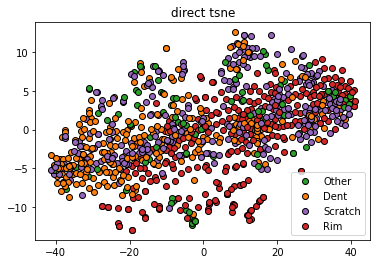

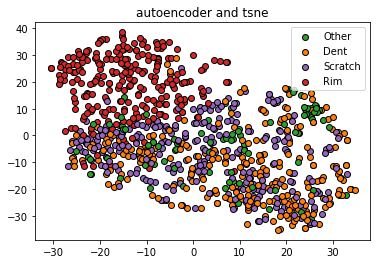

In [7]:
plt.title('direct tsne')
for i in range(0, X_only.shape[0]):
    plt.scatter(X_only[i, 0], X_only[i, 1],cmap = ListedColormap(["#FF0000", "#0000FF"]), c=np.array(plt.cm.tab10(dataLabel.loc[i, "human_label"])).reshape(1,-1),label=dataLabel.loc[i, "label_name"], edgecolor="k")

plt.legend()
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())
plt.show()


plt.title('autoencoder and tsne')
for i in range(0, X_auto.shape[0]):
    plt.scatter(X_auto[i, 0], X_auto[i, 1],cmap = ListedColormap(["#FF0000", "#0000FF"]), c=np.array(plt.cm.tab10(dataLabel.loc[i, "human_label"])).reshape(1,-1),label=dataLabel.loc[i, "label_name"], edgecolor="k")

plt.legend()
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())
plt.show()

**<font> 
Looking at the picture above, we find that there are obvious differences between the wheel hub and other types of damage. There are many overlapping parts of dents and scratches, and other types of damage do not belong to the above three types. This is similar to what we encountered with the labels at the time, the hubs were very easy to label, and there was some controversy among the panelists on the dented and scratched labels. The other is in the group members' opinion that does not belong to the above three types of injury.
</font>** 

**<font> 
At the same time, since the error of the fault photo is high-dimensional data, the information loss is relatively large after reducing to two dimensions, for example, many other types of points overlap with depressions and scratches.
</font>** 

**<font> 
The accuracy of fault classification under 2D data is lower, but this method helps us to find the wrong labels. After correction, about 30 wrong labels have been modified.
</font>** 

Reclassify based on corrected labels

In [8]:
dataLabel1 = pd.read_csv("label0-896_final_new.csv")

y1 = dataLabel1.loc[:, "label_name"]

**<font>
To detect the effect of label correction, we call a simple SVM classifier for evaluation, and the accuracy is slightly improved. We successfully eliminate mislabeled data due to carelessness and unclear standards.
</font>**     

0.6055555555555555
              precision    recall  f1-score   support

        Dent       0.48      0.57      0.53        54
       Other       0.33      0.12      0.18        16
         Rim       0.98      0.90      0.94        52
     Scratch       0.47      0.50      0.48        58

    accuracy                           0.61       180
   macro avg       0.57      0.53      0.53       180
weighted avg       0.61      0.61      0.60       180



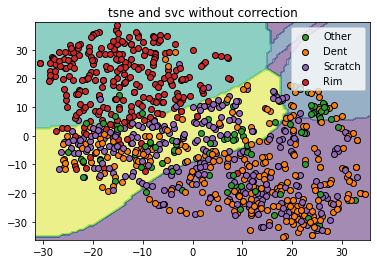

0.6666666666666666
              precision    recall  f1-score   support

        Dent       0.54      0.67      0.60        54
       Other       0.50      0.21      0.30        14
         Rim       0.98      0.90      0.94        52
     Scratch       0.53      0.52      0.52        60

    accuracy                           0.65       180
   macro avg       0.64      0.58      0.59       180
weighted avg       0.66      0.65      0.65       180



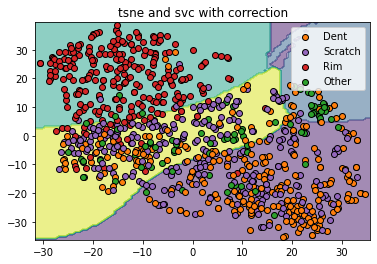

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X_auto, y, test_size=0.2, random_state=42)

svc = SVC(random_state=42, C=2, degree=2,kernel="rbf")
svc.fit(X_train, y_train)
acc_knn = svc.score(X_test, y_test)
print(acc_knn)
print(classification_report(y_test,svc.predict(X_test)))
disp = DecisionBoundaryDisplay.from_estimator(svc, X_auto, response_method="predict",alpha=0.5)
for i in range(0, X_auto.shape[0]):
    disp.ax_.scatter(X_auto[i, 0], X_auto[i, 1],cmap = ListedColormap(["#FF0000", "#0000FF"]), c=np.array(plt.cm.tab10(dataLabel.loc[i, "human_label"])).reshape(1,-1),label=dataLabel.loc[i, "label_name"], edgecolor="k")

plt.legend()
plt.title('tsne and svc without correction')
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())
plt.show()




X_train1, X_test1, y_train1, y_test1 = train_test_split(X_auto, y1, test_size=0.2, random_state=42)

svc1 = SVC(random_state=42, C=2, degree=2,kernel="rbf")
svc1.fit(X_train1, y_train1)
acc_knn = svc.score(X_test1, y_test1)
print(acc_knn)
print(classification_report(y_test1,svc1.predict(X_test1)))
disp = DecisionBoundaryDisplay.from_estimator(svc1, X_auto, response_method="predict",alpha=0.5)
for i in range(0, X_auto.shape[0]):
    disp.ax_.scatter(X_auto[i, 0], X_auto[i, 1],cmap = ListedColormap(["#FF0000", "#0000FF"]), c=np.array(plt.cm.tab10(dataLabel1.loc[i, "human_label"])).reshape(1,-1),label=dataLabel1.loc[i, "label_name"], edgecolor="k")

plt.legend()
plt.title('tsne and svc with correction')
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())
plt.show()

## Active learning correct labels for new coming images
**<font> 
According to project requirements, the user can modify wrong predictions from the model or help the model to validate uncertain predictions if it is right or wrong. Based on the new input images, it could further finish the re-training tasks. In this case, active learning is a very suitable method, the details of this method are described in the active learning documentation in Gitlab.
</font>** 